In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.bert_conf
encoding_type = 'pos'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_pos_about'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5739422275941131 	 Validation loss: 0.41046528745505767 	 
  1%|          | 574/57400 [01:47<2:40:12,  5.91it/s]
Epoch 2 	 Training loss: 0.38380668148761843 	 Validation loss: 0.35267224655313006 	 
  2%|▏         | 1148/57400 [03:38<2:53:17,  5.41it/s]
Epoch 3 	 Training loss: 0.3435166465696142 	 Validation loss: 0.33386107647823077 	 
  3%|▎         | 1722/57400 [05:29<2:48:48,  5.50it/s]
Epoch 4 	 Training loss: 0.3226589833090945 	 Validation loss: 0.3263534140788903 	 
  4%|▍         | 2296/57400 [07:20<2:25:56,  6.29it/s]
Epoch 5 	 Training loss: 0.30712744912930895 	 Validation loss: 0.3177477389068927 	 
  5%|▌         | 2870/57400 [09:10<2:32:03,  5.98it/s]
Epoch 6 	 Training loss: 0.29520190655146744 	 Validation loss: 0.3126087489269547 	 
  6%|▌         | 3444/57400 [11:01<2:37:25,  5.71it/s]
Epoch 7 	 Training loss: 0.2849111163709637 	 Validation loss: 0.30736443854994694 	 
  7%|▋         | 4018/57400 [12:52<2:35:39,  5.72it/s]
Epoch 8 	 Trai

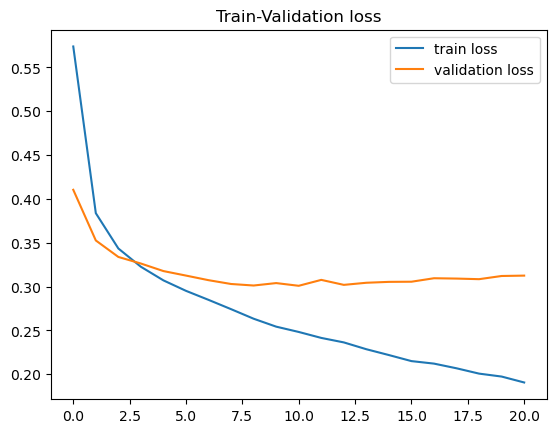

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8456632653061225, 'precision': 0.8456632653061225, 'f1': 0.8456632653061225, 'accuracy': 0.8456632653061225}
MALE {'recall': 0.859375, 'precision': 0.859375, 'f1': 0.859375, 'accuracy': 0.859375}
FEMALE {'recall': 0.8325, 'precision': 0.8325, 'f1': 0.8325, 'accuracy': 0.8325} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6805555555555556, 'precision': 0.6805555555555556, 'f1': 0.6805555555555556, 'accuracy': 0.6805555555555556}
MALE {'recall': 0.708029197080292, 'precision': 0.708029197080292, 'f1': 0.708029197080292, 'accuracy': 0.708029197080292}
FEMALE {'recall': 0.6509186351706037, 'precision': 0.6509186351706037, 'f1': 0.6509186351706037, 'accuracy': 0.6509186351706037} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6805736636245111, 'precision': 0.6805736636245111, 'f1': 0.6805736636245111, 'accuracy': 0.6805736636245111}
MALE {'recall': 0.696969696969697, 'precision': 0.6969696969

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5981237330191642 	 Validation loss: 0.4067463248463 	 
  1%|          | 574/57400 [01:45<2:38:22,  5.98it/s]
Epoch 2 	 Training loss: 0.383237315802624 	 Validation loss: 0.35359943620229173 	 
  2%|▏         | 1148/57400 [03:30<2:33:28,  6.11it/s]
Epoch 3 	 Training loss: 0.3455111056514318 	 Validation loss: 0.3432544520345785 	 
  3%|▎         | 1722/57400 [05:15<2:39:52,  5.80it/s]
Epoch 4 	 Training loss: 0.32519864137787435 	 Validation loss: 0.32844164386644203 	 
  4%|▍         | 2296/57400 [07:00<2:53:02,  5.31it/s]
Epoch 5 	 Training loss: 0.31001731052423603 	 Validation loss: 0.3200610264883203 	 
  5%|▌         | 2870/57400 [08:45<2:39:00,  5.72it/s]
Epoch 6 	 Training loss: 0.2961107140945641 	 Validation loss: 0.31452707845275685 	 
  6%|▌         | 3444/57400 [10:30<2:24:01,  6.24it/s]
Epoch 7 	 Training loss: 0.28565937927064167 	 Validation loss: 0.3094778060913086 	 
  7%|▋         | 4018/57400 [12:14<2:19:41,  6.37it/s]
Epoch 8 	 Training 

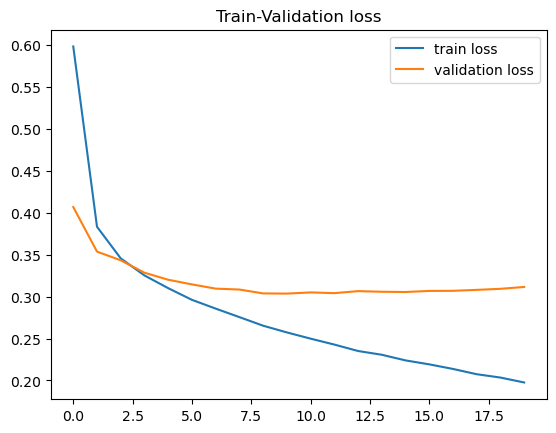

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_pos_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8558673469387755, 'precision': 0.8558673469387755, 'f1': 0.8558673469387755, 'accuracy': 0.8558673469387755}
MALE {'recall': 0.8697916666666666, 'precision': 0.8697916666666666, 'f1': 0.8697916666666666, 'accuracy': 0.8697916666666666}
FEMALE {'recall': 0.8425, 'precision': 0.8425, 'f1': 0.8425, 'accuracy': 0.8425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.678030303030303, 'precision': 0.678030303030303, 'f1': 0.678030303030303, 'accuracy': 0.678030303030303}
MALE {'recall': 0.7104622871046229, 'precision': 0.7104622871046229, 'f1': 0.7104622871046229, 'accuracy': 0.7104622871046229}
FEMALE {'recall': 0.6430446194225722, 'precision': 0.6430446194225722, 'f1': 0.6430446194225722, 'accuracy': 0.6430446194225722} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6897001303780965, 'precision': 0.6897001303780965, 'f1': 0.6897001303780965, 'accuracy': 0.6897001303780965}
MALE {'recall': 0.71

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.560099881285159 	 Validation loss: 0.3937787231752428 	 
  1%|          | 574/57400 [01:44<2:43:28,  5.79it/s]
Epoch 2 	 Training loss: 0.37641212650500105 	 Validation loss: 0.34862831639031233 	 
  2%|▏         | 1148/57400 [03:28<2:17:33,  6.82it/s]
Epoch 3 	 Training loss: 0.34178712553886587 	 Validation loss: 0.3327222405853918 	 
  3%|▎         | 1722/57400 [05:12<2:25:30,  6.38it/s]
Epoch 4 	 Training loss: 0.3208500770430116 	 Validation loss: 0.3237097682589192 	 
  4%|▍         | 2296/57400 [06:58<2:27:29,  6.23it/s]
Epoch 5 	 Training loss: 0.30624492718263785 	 Validation loss: 0.3172009347353951 	 
  5%|▌         | 2870/57400 [08:43<2:27:23,  6.17it/s]
Epoch 6 	 Training loss: 0.2933885250565067 	 Validation loss: 0.30910251150696966 	 
  6%|▌         | 3444/57400 [10:28<2:36:45,  5.74it/s]
Epoch 7 	 Training loss: 0.2830955388498223 	 Validation loss: 0.3065603668406858 	 
  7%|▋         | 4018/57400 [12:13<2:37:22,  5.65it/s]
Epoch 8 	 Trainin

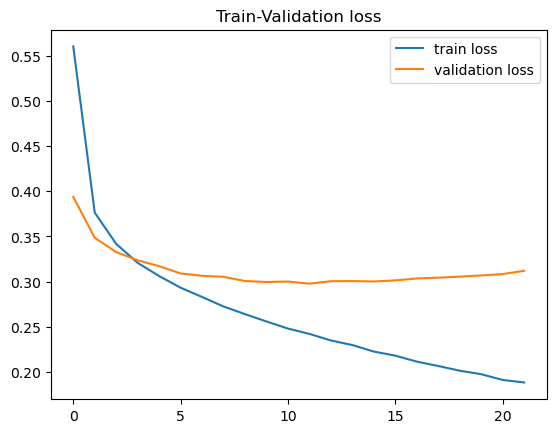

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_pos_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8507653061224489, 'precision': 0.8507653061224489, 'f1': 0.8507653061224489, 'accuracy': 0.8507653061224489}
MALE {'recall': 0.8671875, 'precision': 0.8671875, 'f1': 0.8671875, 'accuracy': 0.8671875}
FEMALE {'recall': 0.835, 'precision': 0.835, 'f1': 0.835, 'accuracy': 0.835} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6767676767676768, 'precision': 0.6767676767676768, 'f1': 0.6767676767676768, 'accuracy': 0.6767676767676768}
MALE {'recall': 0.7031630170316302, 'precision': 0.7031630170316302, 'f1': 0.7031630170316302, 'accuracy': 0.7031630170316302}
FEMALE {'recall': 0.6482939632545932, 'precision': 0.6482939632545932, 'f1': 0.6482939632545932, 'accuracy': 0.6482939632545932} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6883963494132985, 'precision': 0.6883963494132985, 'f1': 0.6883963494132985, 'accuracy': 0.6883963494132985}
MALE {'recall': 0.7045454545454546, 'precision': 0.70454

Resultados finales

In [23]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.8507653061224489, 'precision': 0.8507653061224489, 'f1': 0.8507653061224489, 'accuracy': 0.8507653061224489}
Métricas etiqueta male: {'recall': 0.8654513888888888, 'precision': 0.8654513888888888, 'f1': 0.8654513888888888, 'accuracy': 0.8654513888888888}
Métricas etiqueta female:  {'recall': 0.8366666666666667, 'precision': 0.8366666666666667, 'f1': 0.8366666666666667, 'accuracy': 0.8366666666666667}

 to
Resultado global: {'recall': 0.6784511784511784, 'precision': 0.6784511784511784, 'f1': 0.6784511784511784, 'accuracy': 0.6784511784511784}
Métricas etiqueta male: {'recall': 0.7072181670721817, 'precision': 0.7072181670721817, 'f1': 0.7072181670721817, 'accuracy': 0.7072181670721817}
Métricas etiqueta female:  {'recall': 0.647419072615923, 'precision': 0.647419072615923, 'f1': 0.647419072615923, 'accuracy': 0.647419072615923}

 as
Resultado global: {'recall': 0.6862233811386353, 'precision': 0.6862233811386353, 'f1': 0.68622

# TO

In [24]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.694898735459258 	 Validation loss: 0.6933908795906325 	 
  1%|          | 574/57400 [01:44<2:41:28,  5.87it/s]
Epoch 2 	 Training loss: 0.694532804372834 	 Validation loss: 0.6923316161511308 	 
  2%|▏         | 1148/57400 [03:30<2:41:59,  5.79it/s]
Epoch 3 	 Training loss: 0.6940532025559853 	 Validation loss: 0.693902238950891 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:16<2:42:15,  5.72it/s]
Epoch 4 	 Training loss: 0.6934334586929362 	 Validation loss: 0.6922473685216095 	 
  4%|▍         | 2296/57400 [07:00<2:40:33,  5.72it/s]
Epoch 5 	 Training loss: 0.6932006650685433 	 Validation loss: 0.6928617186465506 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:45<2:31:03,  6.02it/s]
Epoch 6 	 Training loss: 0.6931042558017093 	 Validation loss: 0.6939798361164028 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:31<2:39:27,  5.64it/s]
Epoch 7 	 Training loss: 0.6930523383908156 	 Validation loss: 0.693029523906

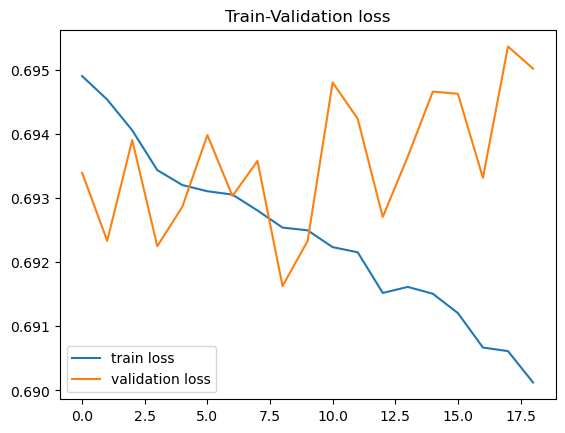

In [25]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_pos_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [26]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5267857142857143, 'precision': 0.5267857142857143, 'f1': 0.5267857142857143, 'accuracy': 0.5267857142857143}
MALE {'recall': 0.2682291666666667, 'precision': 0.2682291666666667, 'f1': 0.2682291666666667, 'accuracy': 0.2682291666666667}
FEMALE {'recall': 0.775, 'precision': 0.775, 'f1': 0.775, 'accuracy': 0.775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5391414141414141, 'precision': 0.5391414141414141, 'f1': 0.5391414141414141, 'accuracy': 0.5391414141414141}
MALE {'recall': 0.3260340632603406, 'precision': 0.3260340632603406, 'f1': 0.3260340632603406, 'accuracy': 0.3260340632603406}
FEMALE {'recall': 0.7690288713910761, 'precision': 0.7690288713910761, 'f1': 0.7690288713910761, 'accuracy': 0.7690288713910761} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 0.272727

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.696839851265585 	 Validation loss: 0.6943838768086191 	 
  1%|          | 574/57400 [01:45<2:44:29,  5.76it/s]
Epoch 2 	 Training loss: 0.6944345254515937 	 Validation loss: 0.693726612349688 	 
  2%|▏         | 1148/57400 [03:31<2:37:13,  5.96it/s]
Epoch 3 	 Training loss: 0.6936811610589044 	 Validation loss: 0.6927852772049985 	 
  3%|▎         | 1722/57400 [05:17<2:42:03,  5.73it/s]
Epoch 4 	 Training loss: 0.6934240277635927 	 Validation loss: 0.6922582286899372 	 
  4%|▍         | 2296/57400 [07:02<2:30:57,  6.08it/s]
Epoch 5 	 Training loss: 0.6933414112607776 	 Validation loss: 0.6929033499653057 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:48<2:36:31,  5.81it/s]
Epoch 6 	 Training loss: 0.6931119187368333 	 Validation loss: 0.6932793178800809 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:33<2:15:22,  6.64it/s]
Epoch 7 	 Training loss: 0.6927168214570355 	 Validation loss: 0.693310731548374 	 

3 epoch without impr

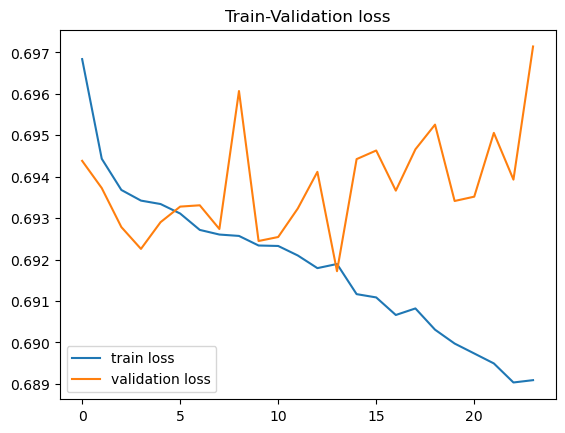

In [27]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_pos_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [28]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5701530612244898, 'precision': 0.5701530612244898, 'f1': 0.5701530612244898, 'accuracy': 0.5701530612244898}
MALE {'recall': 0.3020833333333333, 'precision': 0.3020833333333333, 'f1': 0.3020833333333333, 'accuracy': 0.3020833333333333}
FEMALE {'recall': 0.8275, 'precision': 0.8275, 'f1': 0.8275, 'accuracy': 0.8275} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5454545454545454, 'precision': 0.5454545454545454, 'f1': 0.5454545454545454, 'accuracy': 0.5454545454545454}
MALE {'recall': 0.35766423357664234, 'precision': 0.35766423357664234, 'f1': 0.35766423357664234, 'accuracy': 0.35766423357664234}
FEMALE {'recall': 0.7480314960629921, 'precision': 0.7480314960629921, 'f1': 0.7480314960629921, 'accuracy': 0.7480314960629921} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5514993481095176, 'precision': 0.5514993481095176, 'f1': 0.5514993481095176, 'accuracy': 0.5514993481095176}
MALE {'recal

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6949598240935428 	 Validation loss: 0.6920458553201061 	 
  1%|          | 574/57400 [01:45<2:50:45,  5.55it/s]
Epoch 2 	 Training loss: 0.6950915000995277 	 Validation loss: 0.6928283279224977 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:30<2:58:33,  5.25it/s]
Epoch 3 	 Training loss: 0.6949400522775351 	 Validation loss: 0.6938149838124291 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:16<2:43:57,  5.66it/s]
Epoch 4 	 Training loss: 0.6947195244375421 	 Validation loss: 0.6937158107757568 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [07:01<2:48:42,  5.44it/s]
Epoch 5 	 Training loss: 0.6940514391307632 	 Validation loss: 0.6940463478282347 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [08:46<2:31:34,  6.00it/s]
Epoch 6 	 Training loss: 0.6938999096898667 	 Validation loss: 0.6936276110552125 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [10:30<2:53:14,  5.19it/s]
Epoch 7 	 Traini

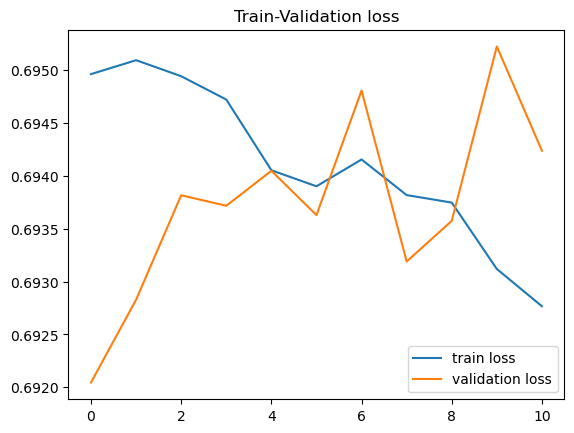

In [29]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_pos_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [30]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5688775510204082, 'precision': 0.5688775510204082, 'f1': 0.5688775510204082, 'accuracy': 0.5688775510204082}
MALE {'recall': 0.2916666666666667, 'precision': 0.2916666666666667, 'f1': 0.2916666666666667, 'accuracy': 0.2916666666666667}
FEMALE {'recall': 0.835, 'precision': 0.835, 'f1': 0.835, 'accuracy': 0.835} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5353535353535354, 'precision': 0.5353535353535354, 'f1': 0.5353535353535354, 'accuracy': 0.5353535353535354}
MALE {'recall': 0.3236009732360097, 'precision': 0.3236009732360097, 'f1': 0.3236009732360097, 'accuracy': 0.3236009732360097}
FEMALE {'recall': 0.7637795275590551, 'precision': 0.7637795275590551, 'f1': 0.7637795275590551, 'accuracy': 0.7637795275590551} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5501955671447197, 'precision': 0.5501955671447197, 'f1': 0.5501955671447197, 'accuracy': 0.5501955671447197}
MALE {'recall': 0.31

Resultados finales

In [31]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.5552721088435374, 'precision': 0.5552721088435374, 'f1': 0.5552721088435374, 'accuracy': 0.5552721088435374}
Métricas etiqueta male: {'recall': 0.2873263888888889, 'precision': 0.2873263888888889, 'f1': 0.2873263888888889, 'accuracy': 0.2873263888888889}
Métricas etiqueta female:  {'recall': 0.8125, 'precision': 0.8125, 'f1': 0.8125, 'accuracy': 0.8125}

 to
Resultado global: {'recall': 0.539983164983165, 'precision': 0.539983164983165, 'f1': 0.539983164983165, 'accuracy': 0.539983164983165}
Métricas etiqueta male: {'recall': 0.3357664233576642, 'precision': 0.3357664233576642, 'f1': 0.3357664233576642, 'accuracy': 0.3357664233576642}
Métricas etiqueta female:  {'recall': 0.7602799650043744, 'precision': 0.7602799650043744, 'f1': 0.7602799650043744, 'accuracy': 0.7602799650043744}

 as
Resultado global: {'recall': 0.5393307257714037, 'precision': 0.5393307257714037, 'f1': 0.5393307257714037, 'accuracy': 0.5393307257714037}
Mét

# AS

In [32]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6957147271998668 	 Validation loss: 0.6934937006336147 	 
  1%|          | 574/57400 [01:45<2:26:59,  6.44it/s]
Epoch 2 	 Training loss: 0.6950318284774076 	 Validation loss: 0.6918644591913385 	 
  2%|▏         | 1148/57400 [03:30<3:35:06,  4.36it/s]
Epoch 3 	 Training loss: 0.6938466116111037 	 Validation loss: 0.6918924440771846 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:15<3:11:34,  4.84it/s]
Epoch 4 	 Training loss: 0.6922318153472727 	 Validation loss: 0.6941208132242752 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [06:59<2:42:14,  5.66it/s]
Epoch 5 	 Training loss: 0.6911587749416405 	 Validation loss: 0.6926572383460352 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [08:44<2:32:42,  5.95it/s]
Epoch 6 	 Training loss: 0.6901084272911324 	 Validation loss: 0.6921850937907978 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [10:29<2:47:43,  5.36it/s]
Epoch 7 	 Training loss: 0.6882335232109974 	

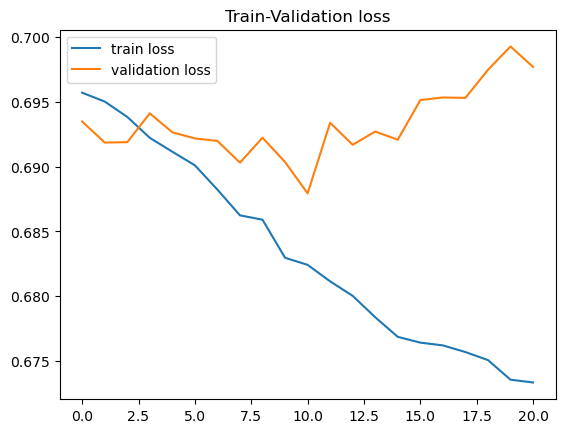

In [33]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_pos_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [34]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6492346938775511, 'precision': 0.6492346938775511, 'f1': 0.6492346938775511, 'accuracy': 0.6492346938775511}
MALE {'recall': 0.5989583333333334, 'precision': 0.5989583333333334, 'f1': 0.5989583333333334, 'accuracy': 0.5989583333333334}
FEMALE {'recall': 0.6975, 'precision': 0.6975, 'f1': 0.6975, 'accuracy': 0.6975} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6477272727272727, 'precision': 0.6477272727272727, 'f1': 0.6477272727272727, 'accuracy': 0.6477272727272727}
MALE {'recall': 0.6253041362530414, 'precision': 0.6253041362530414, 'f1': 0.6253041362530414, 'accuracy': 0.6253041362530414}
FEMALE {'recall': 0.6719160104986877, 'precision': 0.6719160104986877, 'f1': 0.6719160104986877, 'accuracy': 0.6719160104986877} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7183833116036505, 'precision': 0.7183833116036505, 'f1': 0.7183833116036505, 'accuracy': 0.7183833116036505}
MALE {'recall': 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6949532945812371 	 Validation loss: 0.6924639394727804 	 
  1%|          | 574/57400 [01:45<2:32:19,  6.22it/s]
Epoch 2 	 Training loss: 0.6936090656066191 	 Validation loss: 0.6930006136328487 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:29<2:37:51,  5.94it/s]
Epoch 3 	 Training loss: 0.6929329607752558 	 Validation loss: 0.691575909064988 	 
  3%|▎         | 1722/57400 [05:15<3:01:59,  5.10it/s]
Epoch 4 	 Training loss: 0.691794831889847 	 Validation loss: 0.6913330090247979 	 
  4%|▍         | 2296/57400 [07:00<2:46:37,  5.51it/s]
Epoch 5 	 Training loss: 0.6899917871279169 	 Validation loss: 0.6920136647709345 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:44<2:21:42,  6.41it/s]
Epoch 6 	 Training loss: 0.6886592846921927 	 Validation loss: 0.6913998510877964 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:29<3:15:28,  4.60it/s]
Epoch 7 	 Training loss: 0.6869995028092055 	 Validation loss: 0.69073813446

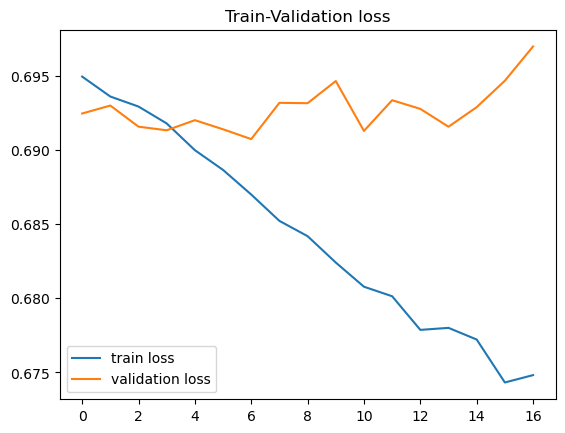

In [35]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_pos_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [36]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6683673469387755, 'precision': 0.6683673469387755, 'f1': 0.6683673469387755, 'accuracy': 0.6683673469387755}
MALE {'recall': 0.6666666666666666, 'precision': 0.6666666666666666, 'f1': 0.6666666666666666, 'accuracy': 0.6666666666666666}
FEMALE {'recall': 0.67, 'precision': 0.67, 'f1': 0.67, 'accuracy': 0.67} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6616161616161617, 'precision': 0.6616161616161617, 'f1': 0.6616161616161617, 'accuracy': 0.6616161616161617}
MALE {'recall': 0.6496350364963503, 'precision': 0.6496350364963503, 'f1': 0.6496350364963503, 'accuracy': 0.6496350364963503}
FEMALE {'recall': 0.6745406824146981, 'precision': 0.6745406824146981, 'f1': 0.6745406824146981, 'accuracy': 0.6745406824146981} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6975228161668839, 'precision': 0.6975228161668839, 'f1': 0.6975228161668839, 'accuracy': 0.6975228161668839}
MALE {'recall': 0.618686

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6955286219767992 	 Validation loss: 0.692671243417061 	 
  1%|          | 574/57400 [01:45<2:41:39,  5.86it/s]
Epoch 2 	 Training loss: 0.6939713300728216 	 Validation loss: 0.692232282484992 	 
  2%|▏         | 1148/57400 [03:30<2:27:08,  6.37it/s]
Epoch 3 	 Training loss: 0.6932762860213423 	 Validation loss: 0.6910680714300124 	 
  3%|▎         | 1722/57400 [05:15<2:55:47,  5.28it/s]
Epoch 4 	 Training loss: 0.6911310717619255 	 Validation loss: 0.6914644938404277 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [07:00<2:26:17,  6.28it/s]
Epoch 5 	 Training loss: 0.6898633408837203 	 Validation loss: 0.6927765415886701 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:45<2:22:25,  6.38it/s]
Epoch 6 	 Training loss: 0.6882399912495231 	 Validation loss: 0.6876816092911413 	 
  6%|▌         | 3444/57400 [10:30<2:55:34,  5.12it/s]
Epoch 7 	 Training loss: 0.6846872646011126 	 Validation loss: 0.6901739360922474 	 

1 epoch without imp

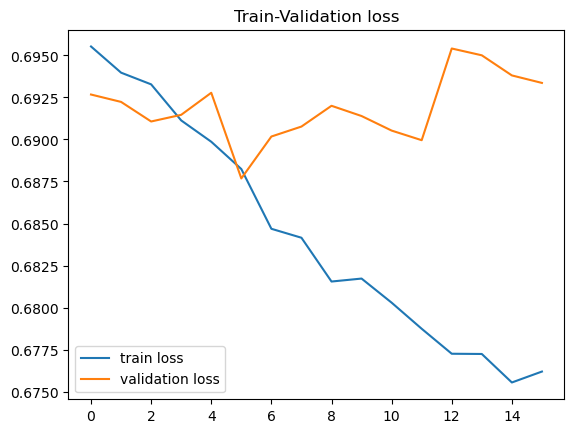

In [37]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_pos_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [38]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7168367346938775, 'precision': 0.7168367346938775, 'f1': 0.7168367346938774, 'accuracy': 0.7168367346938775}
MALE {'recall': 0.625, 'precision': 0.625, 'f1': 0.625, 'accuracy': 0.625}
FEMALE {'recall': 0.805, 'precision': 0.805, 'f1': 0.805, 'accuracy': 0.805} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6717171717171717, 'precision': 0.6717171717171717, 'f1': 0.6717171717171717, 'accuracy': 0.6717171717171717}
MALE {'recall': 0.6155717761557178, 'precision': 0.6155717761557178, 'f1': 0.6155717761557178, 'accuracy': 0.6155717761557178}
FEMALE {'recall': 0.7322834645669292, 'precision': 0.7322834645669292, 'f1': 0.732283464566929, 'accuracy': 0.7322834645669292} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7066492829204694, 'precision': 0.7066492829204694, 'f1': 0.7066492829204694, 'accuracy': 0.7066492829204694}
MALE {'recall': 0.5959595959595959, 'precision': 0.5959595959595959, 'f1'

Resultados finales

In [39]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.6781462585034014, 'precision': 0.6781462585034014, 'f1': 0.6781462585034014, 'accuracy': 0.6781462585034014}
Métricas etiqueta male: {'recall': 0.6302083333333334, 'precision': 0.6302083333333334, 'f1': 0.6302083333333334, 'accuracy': 0.6302083333333334}
Métricas etiqueta female:  {'recall': 0.7241666666666667, 'precision': 0.7241666666666667, 'f1': 0.7241666666666667, 'accuracy': 0.7241666666666667}

 to
Resultado global: {'recall': 0.6603535353535354, 'precision': 0.6603535353535354, 'f1': 0.6603535353535354, 'accuracy': 0.6603535353535354}
Métricas etiqueta male: {'recall': 0.6301703163017032, 'precision': 0.6301703163017032, 'f1': 0.6301703163017032, 'accuracy': 0.6301703163017032}
Métricas etiqueta female:  {'recall': 0.6929133858267716, 'precision': 0.6929133858267716, 'f1': 0.6929133858267716, 'accuracy': 0.6929133858267716}

 as
Resultado global: {'recall': 0.7075184702303347, 'precision': 0.7075184702303347, 'f1': 0.7